In [1]:
import tensorflow as tf
import tensorflow.keras.backend as tf_keras_backend

import numpy as np
from enum import Enum

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
cm_blue_orange = ListedColormap(['blue', 'orange'])

ModuleNotFoundError: No module named 'tensorflow'

In [3]:
def sigmoid(x):
    return 1. / (1. + np.exp(-x))

def relu(x):
    return np.maximum(x, 0.)

def relu_derivative(x):
    return np.heaviside(x, 1.)

def binary_loss(probs, y):
    # probs: predictions y_hat (after applying sigmoid function, they can be interpreted as probabilities)
    # y: target
    eps = tf_keras_backend.epsilon() # 1e-7
    probs = np.clip(probs, eps, 1 - eps)
    return -y * np.log(probs + eps) - (1. - y) * np.log(1. - probs + eps)

In [4]:
class Task(Enum):
    CIRCLE = 'circle'
    STEP = 'step'
    STEPDOWN = 'stepdown'

In [5]:
def generate_dataset(max_x, task): 
    one_third = max_x // 3
    two_thirds = 2 * max_x // 3

    x = np.arange(max_x)
    a = np.repeat(x, max_x)
    b = np.tile(x, max_x)
    inputs = np.array([a, b]).T

    if task == Task.STEP:
        targets = np.logical_and(inputs[:, 0] >= one_third, inputs[:, 1] >= one_third).astype('float32').reshape((-1, 1))
    elif task == Task.STEPDOWN:
        targets = np.logical_and(inputs[:, 0] >= one_third, inputs[:, 1] <= two_thirds).astype('float32').reshape((-1, 1))
    elif task == Task.CIRCLE:
        targets = np.where(inputs[:, 0] ** 2 + inputs[:, 1] ** 2 - two_thirds * max_x >= 0,
                       np.zeros(max_x ** 2), np.ones(max_x ** 2)).astype('float32').reshape((-1, 1))

    return inputs / max_x, targets

In [6]:
# Plot the dataset
def plot_datapoints(X, y, title, fig_name='fig.png'):
    fig, axs = plt.subplots(1, 1, figsize=(5, 5))
    fig.suptitle(title, y=0.93)

    p = axs.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_blue_orange)

    axs.set_xlabel('x1')
    axs.set_ylabel('x2')
    axs.legend(*p.legend_elements(), loc='best', bbox_to_anchor=(0.96, 1.15))   
    
#     fig.savefig(fig_name)

In [7]:
seed = 3000
np.random.seed(seed)

task = Task.STEP

# Generate the dataset
inputs, targets = generate_dataset(max_x=30, task=task)
idx_arr = np.random.permutation(inputs.shape[0])
inputs = inputs[idx_arr, :]
targets = targets[idx_arr]

# Split
train_size = int(inputs.shape[0] * 0.8)
test_size = inputs.shape[0] - train_size
assert train_size + test_size == inputs.shape[0]
print(train_size, test_size)

x_train = inputs[:train_size, :]
y_train = targets[:train_size]

x_test = inputs[train_size:, :]
y_test = targets[train_size:]

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

720 180
(720, 2) (720, 1) (180, 2) (180, 1)


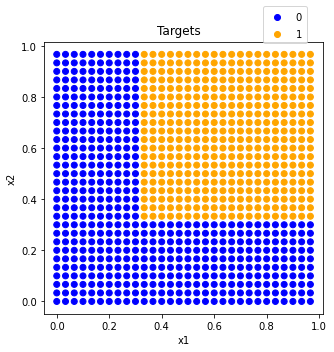

In [8]:
plot_datapoints(inputs, targets, 'Targets', 'targets' + str(task) + '.png')

In [12]:
# Define the forward and backward pass of NN
def forward_pass(x, W1, b1, W2, b2):
    z1 = W1.T @ x + b1
    h1 = relu(z1)
    z2 = W2.T @ h1 + b2
    h2 = sigmoid(z2)

    return z1, h1, z2, h2

def backward_pass(x, W1, b1, W2, b2, z1, h1, z2, h2, y):
    dl_dz2 = (h2 - y).reshape((1, -1)) # in our case, a scalar, but in general, it should be a row-vector, hence reshaping
    dl_W2 = h1 @ dl_dz2
    dl_b2 = dl_dz2.T 
       
    dz2_dh1 = W2.T
    relu_der = relu_derivative(z1)
    dh1_dz1 = np.eye(relu_der.size, dtype=np.float32) * relu_der

    dl_W1 = x @ (dl_dz2.T @ dz2_dh1 @ dh1_dz1)
    dl_b1 = (dl_dz2.T @ dz2_dh1 @ dh1_dz1).T

    return dl_W1, dl_b1, dl_W2, dl_b2

In [13]:
np.random.seed(seed)
tf.random.set_seed(seed)

# Create the model
n_inp = 2
n_hidden = 5 #5 # for Task.STEPDOWN, use n_hidden = 10
n_out = 1

# TF model
inputs = tf.keras.Input(shape=(n_inp,), name="x")
x1 = tf.keras.layers.Dense(n_hidden, activation="relu")(inputs) 
outputs = tf.keras.layers.Dense(n_out, activation="sigmoid", name="predictions")(x1)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Instantiate an optimizer
lr = 0.5  # for Task.STEPDOWN, use lr = 0.99
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
# Instantiate a loss function.
loss_fn = tf.keras.losses.BinaryCrossentropy()
# Prepare the metrics
train_acc_metric = tf.keras.metrics.BinaryAccuracy()
test_acc_metric = tf.keras.metrics.BinaryAccuracy()

# -----------------
# Start from the same weights as the TF model does, before it is trained (copy the weights of the TF model)
# A bad initialization can sometimes be a reason why your model does not learn well. 
# TF has an init that works well.

W1 = model.get_weights()[0]
b1 = model.get_weights()[1].reshape((-1, 1))
W2 = model.get_weights()[2]
b2 = model.get_weights()[3].reshape((-1, 1))

print('Shapes: ', W1.shape, b1.shape, W2.shape, b2.shape)
print('\nW and b before training: ')
print('W1: ', W1)
print('b1: ', b1)
print('W2: ', W2)
print('b2: ', b2)

Shapes:  (2, 5) (5, 1) (5, 1) (1, 1)

W and b before training: 
W1:  [[ 0.74233055 -0.24227977 -0.731178   -0.88009864 -0.6077776 ]
 [-0.06495613 -0.3821292   0.7989758   0.65102196  0.11091197]]
b1:  [[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
W2:  [[ 0.08515286]
 [ 0.59568644]
 [ 0.5218899 ]
 [ 0.29405284]
 [-0.45983934]]
b2:  [[0.]]


In [14]:
epochs = 1000

for epoch in range(epochs):
    
    loss = 0
    z1_arr = np.zeros((x_train.shape[0], n_hidden))
    h1_arr = np.zeros((x_train.shape[0], n_hidden))
    z2_arr = np.zeros((x_train.shape[0], n_out))
    h2_arr = np.zeros((x_train.shape[0], n_out))

    # Forward pass:  
    # propagate all training examples (and save all vars per example), and accumulate the loss
    for i in range(x_train.shape[0]):
        z1, h1, z2, h2 = forward_pass(x_train[i].reshape((-1, 1)), W1, b1, W2, b2)
        z1_arr[i] = z1.squeeze()  # z1.squeeze() does this: (n_hidden, 1) --> (n_hidden,)
        h1_arr[i] = h1.squeeze()
        z2_arr[i] = z2.squeeze()
        h2_arr[i] = h2.squeeze()

        probs = h2
        loss += binary_loss(probs, y_train[i])

    # Backward pass
    delta_W1 = np.zeros_like(W1)
    delta_b1 = np.zeros_like(b1)
    delta_W2 = np.zeros_like(W2)
    delta_b2 = np.zeros_like(b2)

    for i in range(x_train.shape[0]):
        dW1, db1, dW2, db2 = backward_pass(x_train[i].reshape((-1, 1)), 
                                           W1, b1, W2, b2, 
                                           z1_arr[i].reshape((-1, 1)), 
                                           h1_arr[i].reshape((-1, 1)), 
                                           z2_arr[i].reshape((-1, 1)),
                                           h2_arr[i].reshape((-1, 1)),
                                           y_train[i])
        delta_W1 += dW1
        delta_b1 += db1
        delta_W2 += dW2
        delta_b2 += db2

    delta_W1 /= x_train.shape[0]
    delta_b1 /= x_train.shape[0]
    delta_W2 /= x_train.shape[0]
    delta_b2 /= x_train.shape[0]

    W1 -= lr * delta_W1
    b1 -= lr * delta_b1
    W2 -= lr * delta_W2
    b2 -= lr * delta_b2 

    if epoch <= 10 or epoch % 100 == 0 or epoch == epochs - 1:
        actual_output = np.where(h2_arr <= 0.5, np.zeros_like(h2_arr), np.ones_like(h2_arr))
        accuracy = np.sum(actual_output == y_train) / y_train.size
        print(f'Epoch {epoch}. Loss: {float(loss / x_train.shape[0]):.4f}. Accuracy: {accuracy:.4f}')
        
#     # TF model
#     with tf.GradientTape() as tape:
#         out = model(x_train, training=True) 
#         loss_value = loss_fn(y_train, out)

#         grads = tape.gradient(loss_value, model.trainable_weights)
#         optimizer.apply_gradients(zip(grads, model.trainable_weights))

#         train_acc_metric.reset_state()
#         train_acc_metric.update_state(y_train, out)
#         curr_train_acc = train_acc_metric.result()

#     if epoch <= 10 or epoch % 100 == 0 or epoch == epochs - 1:
#         print(f'TF:\nEpoch {epoch}. Loss: {float(loss_value):.4f}. Accuracy: {float(curr_train_acc):.4f}')
#         print('\n')

# Test 
# Forward pass
test_loss = 0
z1_arr = np.zeros((x_test.shape[0], n_hidden))
h1_arr = np.zeros((x_test.shape[0], n_hidden))
z2_arr = np.zeros((x_test.shape[0], n_out))
h2_arr = np.zeros((x_test.shape[0], n_out))

for i in range(x_test.shape[0]):
    z1, h1, z2, h2 = forward_pass(x_test[i].reshape((-1, 1)), W1, b1, W2, b2)
    z1_arr[i] = z1.squeeze()
    h1_arr[i] = h1.squeeze()
    z2_arr[i] = z2.squeeze()
    h2_arr[i] = h2.squeeze()

    probs = h2
    test_loss += binary_loss(probs, y_test[i])

print(f'\nTest loss: {float(test_loss / x_test.shape[0]):.4f}')
actual_output = np.where(h2_arr <= 0.5, np.zeros_like(h2_arr), np.ones_like(h2_arr))
accuracy = np.sum(actual_output == y_test) / y_test.size
print(f'Test accuracy: {accuracy:.4f}')

print('\nW and b after training: ')
print('W1: ', W1)
print('b1: ', b1)
print('W2: ', W2)
print('b2: ', b2)

Epoch 0. Loss: 0.7133. Accuracy: 0.4472
Epoch 1. Loss: 0.7070. Accuracy: 0.5750
Epoch 2. Loss: 0.7014. Accuracy: 0.5278
Epoch 3. Loss: 0.6961. Accuracy: 0.5236
Epoch 4. Loss: 0.6907. Accuracy: 0.5236
Epoch 5. Loss: 0.6853. Accuracy: 0.5486
Epoch 6. Loss: 0.6802. Accuracy: 0.5625
Epoch 7. Loss: 0.6756. Accuracy: 0.5847
Epoch 8. Loss: 0.6715. Accuracy: 0.6014
Epoch 9. Loss: 0.6676. Accuracy: 0.6083
Epoch 10. Loss: 0.6637. Accuracy: 0.6181
Epoch 100. Loss: 0.3295. Accuracy: 0.8486
Epoch 200. Loss: 0.2930. Accuracy: 0.8583
Epoch 300. Loss: 0.2451. Accuracy: 0.8833
Epoch 400. Loss: 0.1818. Accuracy: 0.9250
Epoch 500. Loss: 0.1365. Accuracy: 0.9583
Epoch 600. Loss: 0.1092. Accuracy: 0.9722
Epoch 700. Loss: 0.0920. Accuracy: 0.9806
Epoch 800. Loss: 0.0802. Accuracy: 0.9875
Epoch 900. Loss: 0.0717. Accuracy: 0.9944
Epoch 999. Loss: 0.0651. Accuracy: 1.0000

Test loss: 0.0668
Test accuracy: 1.0000

W and b after training: 
W1:  [[ 0.6397282  -0.24227977 -0.299509   -5.252497   -0.17151086]
 [ 3

In [15]:
# Tensorflow model training 
epochs = 1000
for epoch in range(epochs):

    with tf.GradientTape() as tape:
        out = model(x_train, training=True) 
        loss_value = loss_fn(y_train, out)

        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        train_acc_metric.reset_state()
        train_acc_metric.update_state(y_train, out)
        curr_train_acc = train_acc_metric.result()

    if epoch <= 10 or epoch % 100 == 0 or epoch == epochs - 1:
        print(f'Epoch {epoch}. Loss: {float(loss_value):.4f}. Accuracy: {float(curr_train_acc):.4f}')

#         print(f'Training loss in epoch {epoch}: {float(loss_value):.4f}')
#         print(f'Accuracy in epoch {epoch}: {float(curr_train_acc):.4f}')

        
# Run a test loop at the end of training
test_out = model(x_test, training=False)
loss_value = loss_fn(y_test, test_out)
print(f'Test loss: {float(loss_value):.4f}')
    
# Update test metrics
test_acc_metric.reset_state()
test_acc_metric.update_state(y_test, test_out)
test_acc = test_acc_metric.result()
print(f'Test accuracy: {float(test_acc):.4f}')

Epoch 0. Loss: 0.7133. Accuracy: 0.4472
Epoch 1. Loss: 0.7070. Accuracy: 0.5750
Epoch 2. Loss: 0.7014. Accuracy: 0.5278
Epoch 3. Loss: 0.6961. Accuracy: 0.5250
Epoch 4. Loss: 0.6908. Accuracy: 0.5236
Epoch 5. Loss: 0.6853. Accuracy: 0.5486
Epoch 6. Loss: 0.6802. Accuracy: 0.5667
Epoch 7. Loss: 0.6756. Accuracy: 0.5847
Epoch 8. Loss: 0.6715. Accuracy: 0.6014
Epoch 9. Loss: 0.6675. Accuracy: 0.6083
Epoch 10. Loss: 0.6637. Accuracy: 0.6181
Epoch 100. Loss: 0.3295. Accuracy: 0.8486
Epoch 200. Loss: 0.2928. Accuracy: 0.8583
Epoch 300. Loss: 0.2448. Accuracy: 0.8833
Epoch 400. Loss: 0.1815. Accuracy: 0.9264
Epoch 500. Loss: 0.1363. Accuracy: 0.9583
Epoch 600. Loss: 0.1091. Accuracy: 0.9722
Epoch 700. Loss: 0.0919. Accuracy: 0.9806
Epoch 800. Loss: 0.0802. Accuracy: 0.9875
Epoch 900. Loss: 0.0716. Accuracy: 0.9944
Epoch 999. Loss: 0.0651. Accuracy: 1.0000
Test loss: 0.0667
Test accuracy: 1.0000


In [16]:
model.get_weights()

[array([[ 0.6395799 , -0.24227977, -0.2994177 , -5.2532344 , -0.17150971],
        [ 3.0016823 , -0.3821292 ,  3.7265172 ,  4.1934342 , -2.2283268 ]],
       dtype=float32),
 array([-0.5334198 ,  0.        , -0.08866916,  0.35595456,  2.2124267 ],
       dtype=float32),
 array([[ 3.0261078 ],
        [ 0.59568644],
        [ 3.615591  ],
        [-6.6488566 ],
        [-3.1146169 ]], dtype=float32),
 array([-1.4492072], dtype=float32)]